In [25]:
import numpy as npt
import pandas as pd
import matplotlib.pyplot as plt
# from gym import wrappers
# from gym import spaces
import math
import random
import re
import os
import sys
import seaborn as sns

In [26]:
!python --version

Python 3.12.4


In [27]:
!pip list --version

Package                           Version
--------------------------------- ------------------
aext-assistant                    4.0.15
aext-assistant-server             4.0.15
aext-core                         4.0.15
aext-core-server                  4.0.15
aext-panels                       4.0.15
aext-panels-server                4.0.15
aext-share-notebook               4.0.15
aext-share-notebook-server        4.0.15
aext-shared                       4.0.15
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.1
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio       

In [28]:
import os

def functionfilenameandpath(path='./', extension='.em1.pcap'):
    filepaths = []
    filenames = []

    for root, _, files_list in os.walk(path):
        for file_name in files_list:
            if file_name.endswith(extension):
                file_name_path = os.path.join(root, file_name)
                filenames.append(file_name)
                filepaths.append(file_name_path)

    return filenames, filepaths


In [29]:
folderpath="./server_data"
filenames,filepaths=functionfilenameandpath(folderpath,'em1.pcap')

filepaths.sort()
filenames.sort()
print(filenames)

['l4s_10Mbps_20ms_ecn.em1.pcap']


In [30]:
print(filepaths)

['./server_data\\l4s_10Mbps_20ms_ecn.em1.pcap']


In [31]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


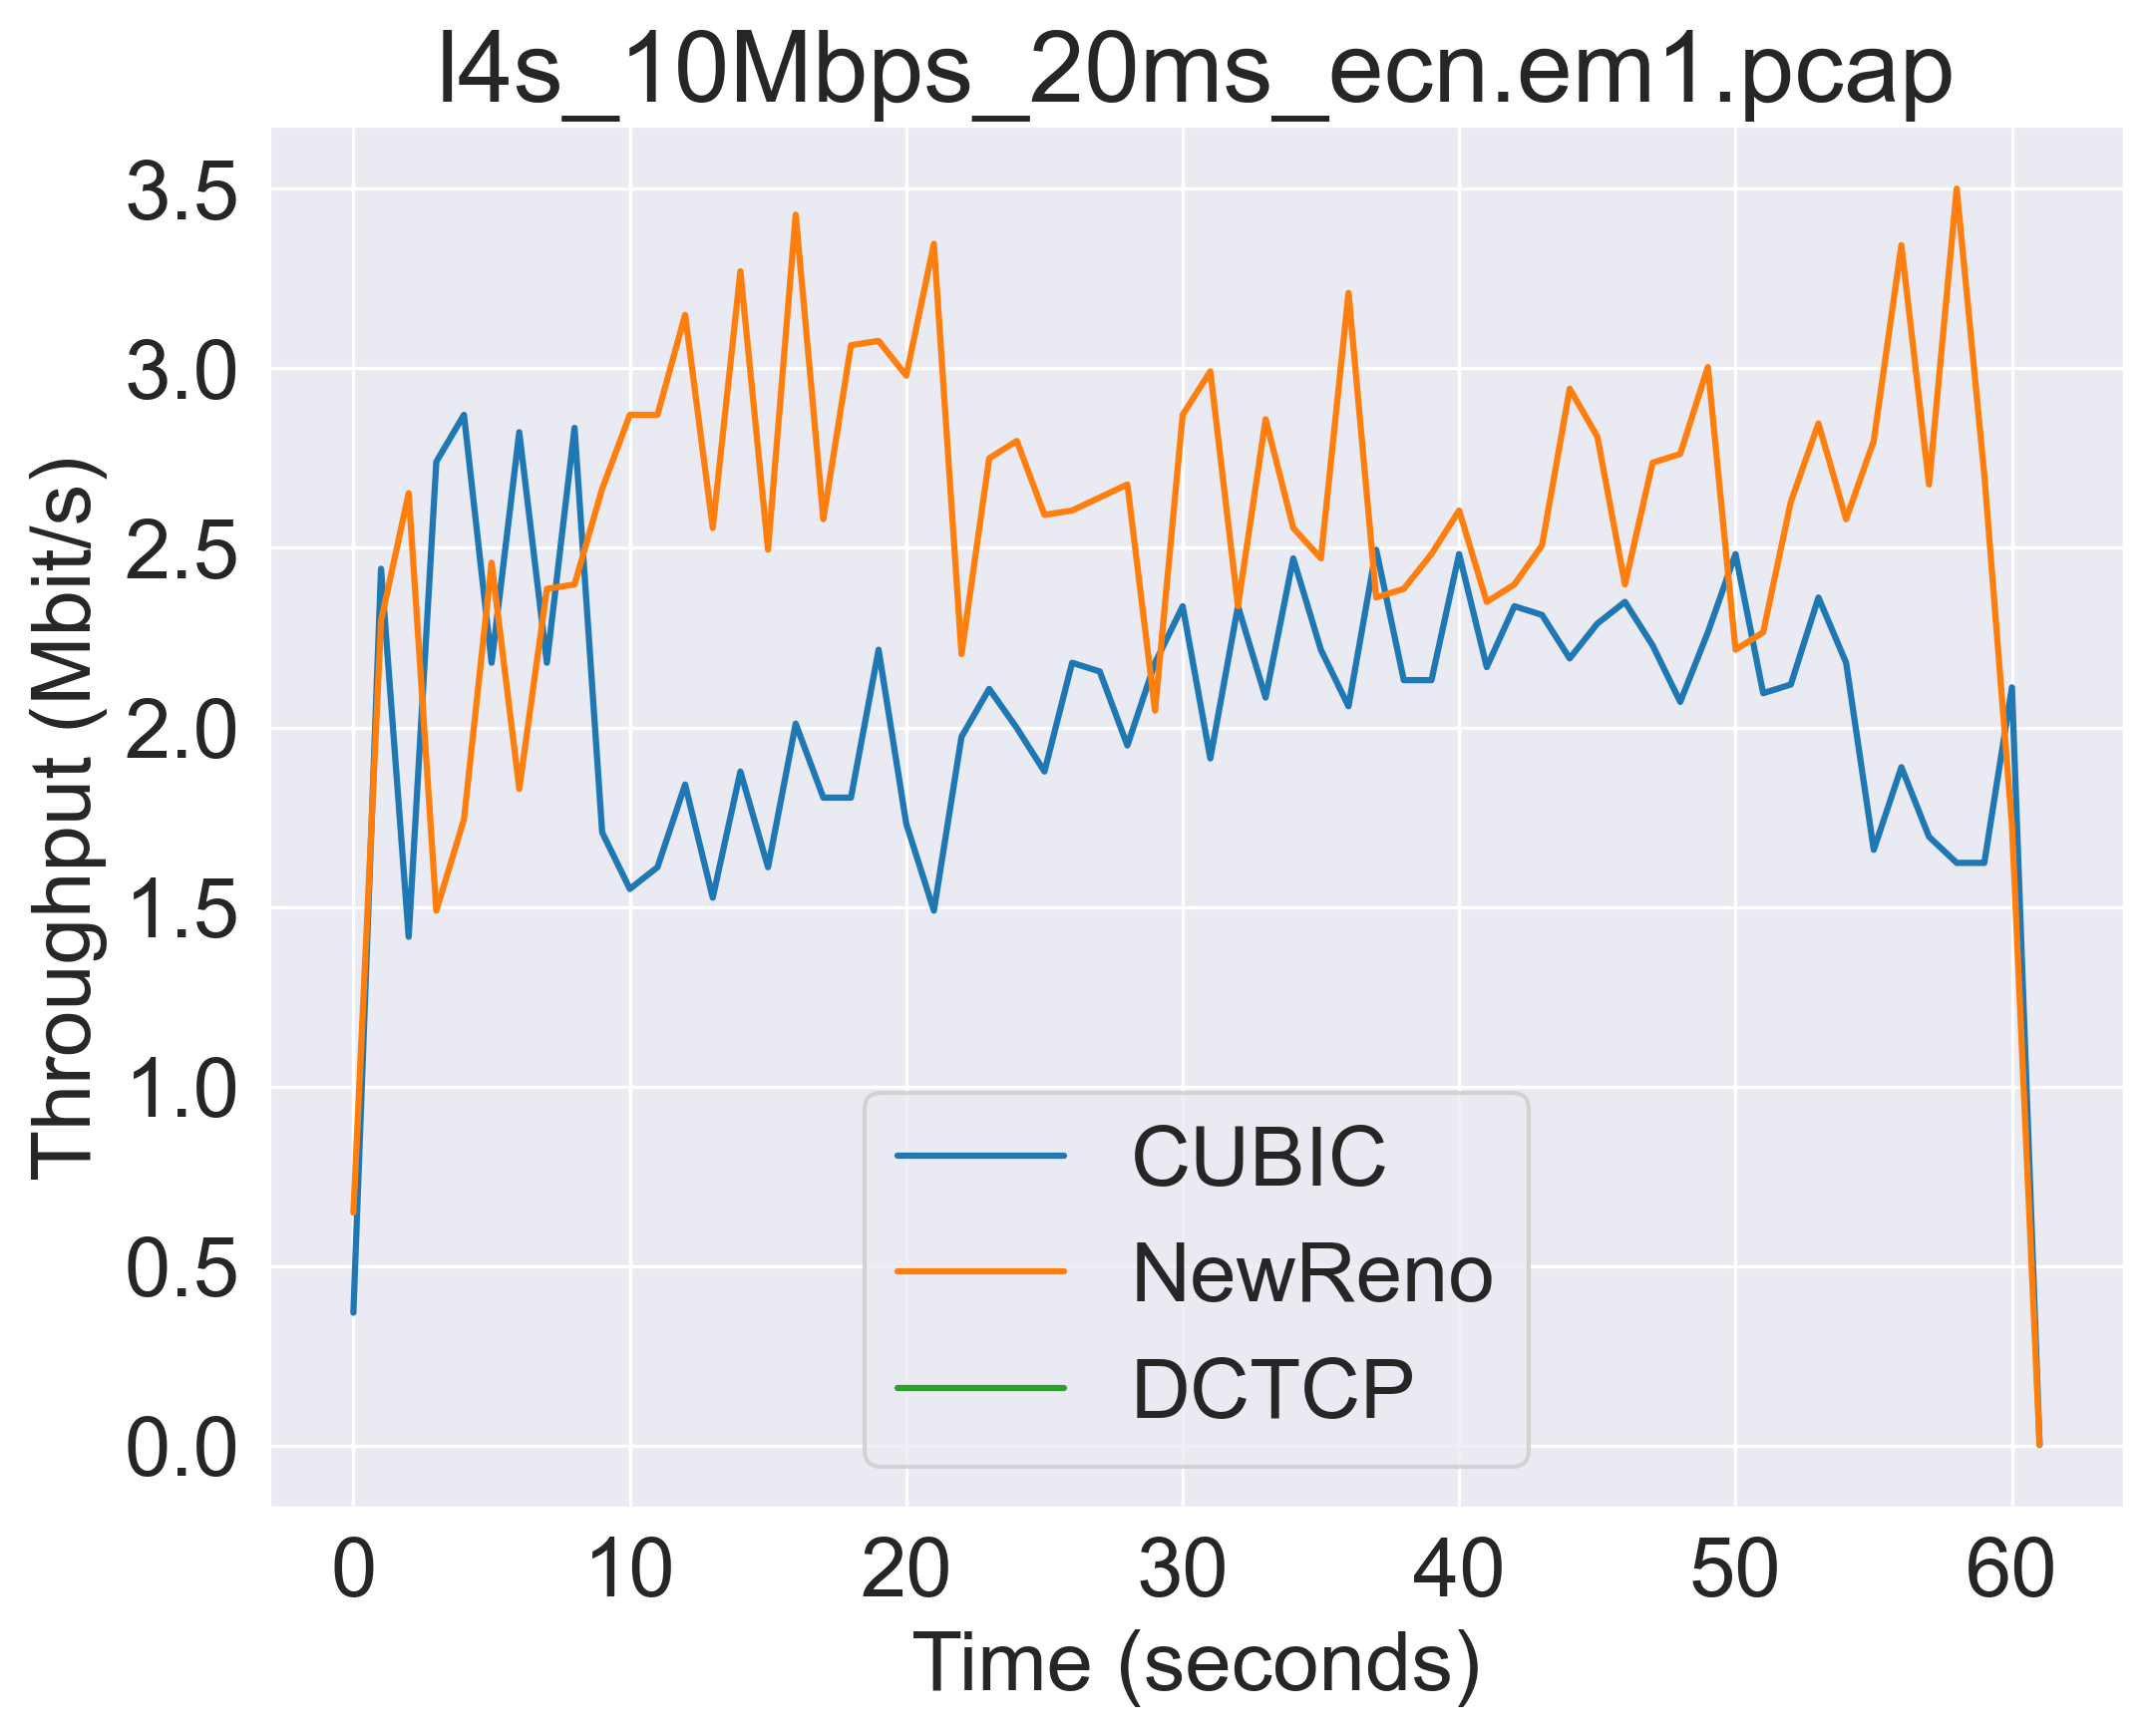

In [32]:
for index in range(len(filenames)):
    throughput = read_pcap(filepaths[index])
    #plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
    plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':300, 'font.size':20})
    sns.set_style("darkgrid")  # Set the style to darkgrid
    
    # Darker color-blind-friendly palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Different line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']

    for i, (port, data) in enumerate(throughput.items()):
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
    
        if port==5101:
            plt.plot(times, mbits_transferred, label=f'CUBIC',color=colors[i])
        elif port==5102:
            plt.plot(times, mbits_transferred, label=f'NewReno',color=colors[i])
        elif port==5103:
            plt.plot(times, mbits_transferred, label=f'DCTCP',color=colors[i])
        
    # if "10Mbps" in filenames[index]:
    #     plt.xlim(0,600)
    #     plt.ylim(0,5.5)
    # elif "1Mbps" in filenames[index]:
    #     plt.xlim(0,600)
    #     plt.ylim(0,0.6)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title(filenames[index])
    plt.legend()
    plt.savefig("./Graphs/"+filenames[index]+"-"+"_Throughput.png", dpi=300,bbox_inches='tight')
    plt.savefig("./Graphs/"+filenames[index]+"-"+"_Throughput.eps", dpi=300,bbox_inches='tight')
    plt.show()